# Compare Seurat feature selection to SEMITONES feature selection methods

## 1. Set up the notebook

### a. Load packages

In [1]:
import pickle
import numpy as np
import os
import pandas as pd
import pickle

from matplotlib import pyplot as plt
from SEMITONES.enrichment_scoring import sig_interval
from SEMITONES.support_funcs import load_sparse_h5
from SEMITONES.support_funcs import sig_dictionary
from sklearn.metrics import silhouette_score

## 2. Do feature selection
Only if interactivity is needed for selection

### a. SEMITONES s.t.d. cut-off

In [2]:
escores = pd.read_csv(
    "../data/processed/greenleaf_scRNA_escores_knn_rbf_8e-1.txt",
    sep="\t", index_col=0
)

In [3]:
pscores = pd.read_csv(
    "../data/interim/greenleaf_scRNA_pscores_knn_rbf_8e-1.txt",
    sep="\t", index_col=0
)

In [4]:
n_sds = [84, 61.6, 52.6, 40.05, 22.254, 15.09, 7.80345]
n_genes = [100, 300, 500, 1000, 3000, 5000, 10000]
for n_sd, n_genes in zip(n_sds, n_genes):
    s = sig_interval(pscores, n_sds=n_sd)
    s = sig_dictionary(escores, s)
    s_genes = []
    for k, v in s.items():
        s_genes.extend(v)
    s_genes = list(set(s_genes))
    with open(f"semitones_ranked_feature_selection_{n_genes}.pkl", "wb") as f:
        pickle.dump(s_genes, f)
    f.close()
    print(len(s_genes))

100
300
500
1000
3000
5000
10000


## 3. Evaluate

### a. Density index

In [5]:
with open("density_indices_RNA.pkl", "rb") as f:
    dis = pickle.load(f)
f.close()

In [6]:
pd.DataFrame(dis)

,100,300,500,1000,3000,5000,10000
semitones,11.730003,9.288106,9.487586,10.479552,16.044977,17.436142,17.811272
seurat,12.613750,8.694369,7.741658,11.827825,16.634388,17.051933,17.615303
seuratv3,11.970255,10.222576,10.830499,12.494380,14.446398,14.762314,15.484312
sem_rank,11.025397,12.574929,14.858219,16.607902,17.416042,17.636741,17.885540


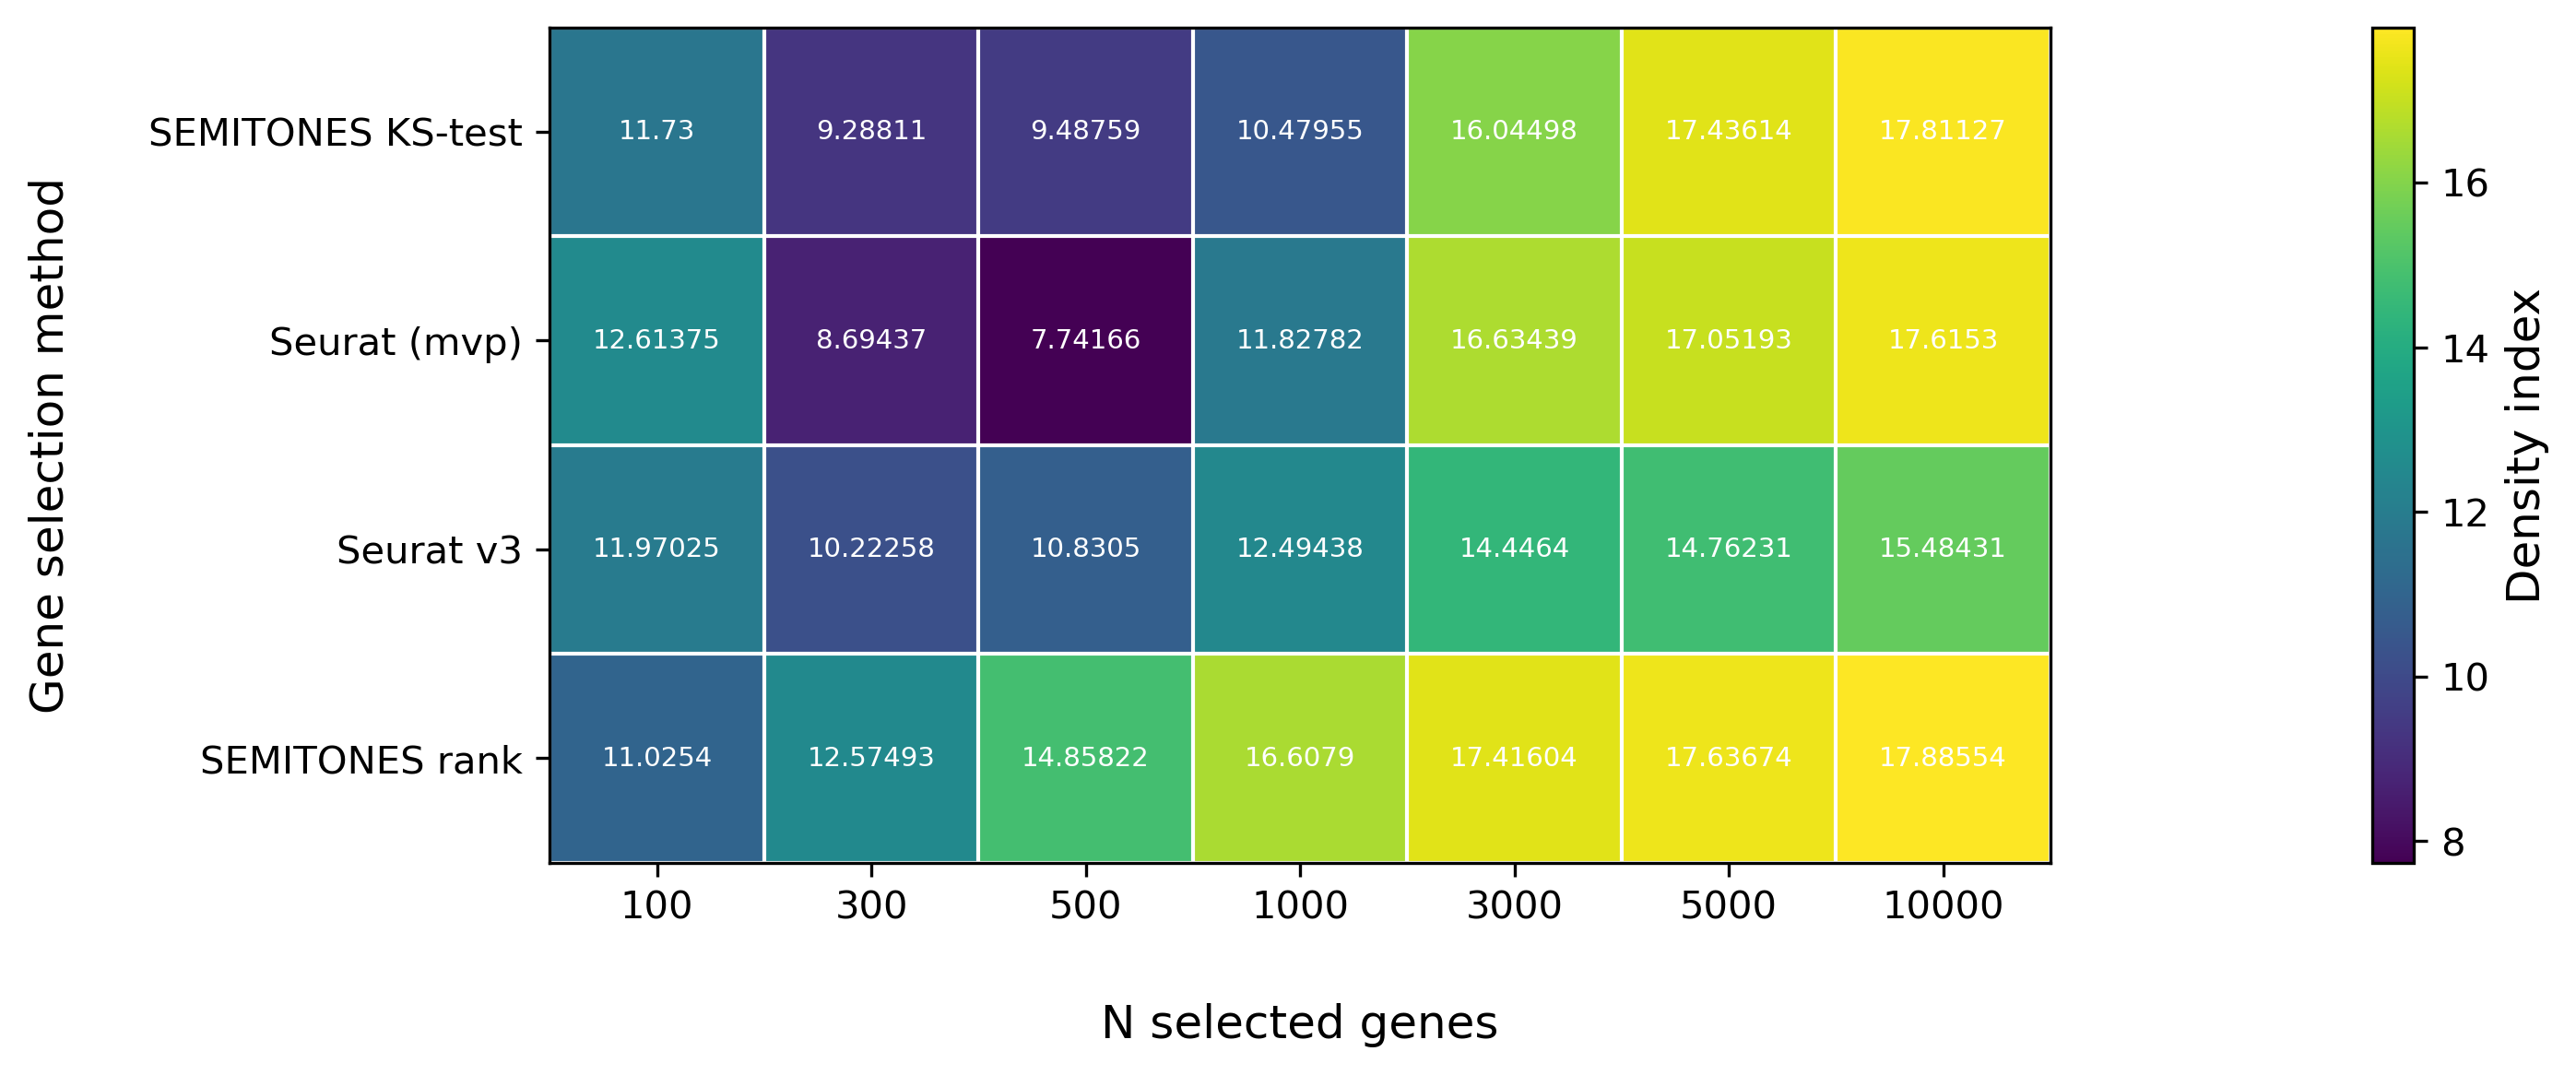

In [7]:
plt.figure(figsize=(10, 4), dpi=300)
plt.imshow(pd.DataFrame(dis), aspect="auto")
cbar = plt.colorbar(pad=.15)
cbar.ax.set_ylabel("Density index", fontsize=12)
ax = plt.gca()

nrows, ncols = 4, 7

ax.set_xticks(range(ncols))
ax.set_xticklabels(dis.keys())
ax.set_xlabel("N selected genes", labelpad=20, fontsize=12)

methods = ["SEMITONES KS-test", "Seurat (mvp)", "Seurat v3", "SEMITONES rank"]
ax.set_yticks(range(nrows))
ax.set_yticklabels(methods)
ax.set_ylabel("Gene selection method", labelpad=20, fontsize=12)

# create text annotations
for i in range(nrows):
    for j in range(ncols):
        text = ax.text(j, i, round(pd.DataFrame(dis).iloc[i, j], 5),
                       ha="center", va="center", color="w",
                       fontsize=7)

ax.set_xticks(np.arange(ncols+1)-.5, minor=True)
ax.set_yticks(np.arange(nrows+1)-.5, minor=True)
ax.grid(b=True, which="minor", axis="both", color="white", linestyle="-", linewidth=1)
ax.tick_params(which="minor", bottom=False, left=False)

Intuitively, when cells are well clustered and therefore
inhomogeneously distributed in feature space, the distance
to nearest neighbours should be minimal relative to the distance between random pairs of cells, and thus DI should be
maximal (Figure 4a,b).

### b. Silhouette coefficient

#### i. Get the annotations from the metadata

In [8]:
# get the barcodes for ordering
with open("../data/processed/greenleaf_scRNA_combined_filtered_barcodes.txt",
          "r") as f:
    barcodes = [b.strip("\n") for b in f.readlines()]
f.close()

# load the metadata
metadata = pd.read_csv(
    "../data/external/greenleaf_scRNA_cell_metadata.txt",
    sep="\t") 

# make cell ID barcodes compatible
metadata["cell_id"] = metadata.Group + ":" + metadata.Barcode
metadata = metadata.set_index("cell_id")  # cell id is index
metadata = metadata.reindex(barcodes)  # order by barcodes
annots = metadata.BioClassification.values  # get annotations
mapping = dict(enumerate(np.unique(annots)))  # mape each annot to an ID
mapping = {v: k for k, v in mapping.items()}  # reverse the mapping
annots = [mapping[i] for i in annots]  # numerical id for each annotation

#### ii. Get the file names for the 50 SVD components

In [9]:
files = os.listdir("")
files = [f for f in files if ("svd50" in f) & ("genes" in f)]
files.sort()

In [10]:
files

['sem_rank_svd50_10000genes.npy',
 'sem_rank_svd50_1000genes.npy',
 'sem_rank_svd50_100genes.npy',
 'sem_rank_svd50_3000genes.npy',
 'sem_rank_svd50_300genes.npy',
 'sem_rank_svd50_5000genes.npy',
 'sem_rank_svd50_500genes.npy',
 'semitones_svd50_10000genes.npy',
 'semitones_svd50_1000genes.npy',
 'semitones_svd50_100genes.npy',
 'semitones_svd50_3000genes.npy',
 'semitones_svd50_300genes.npy',
 'semitones_svd50_5000genes.npy',
 'semitones_svd50_500genes.npy',
 'seurat_svd50_10000genes.npy',
 'seurat_svd50_1000genes.npy',
 'seurat_svd50_100genes.npy',
 'seurat_svd50_3000genes.npy',
 'seurat_svd50_300genes.npy',
 'seurat_svd50_5000genes.npy',
 'seurat_svd50_500genes.npy',
 'seuratv3_svd50_10000genes.npy',
 'seuratv3_svd50_1000genes.npy',
 'seuratv3_svd50_100genes.npy',
 'seuratv3_svd50_3000genes.npy',
 'seuratv3_svd50_300genes.npy',
 'seuratv3_svd50_5000genes.npy',
 'seuratv3_svd50_500genes.npy']

In [11]:
methods = [f.split("_")[0] for f in files]  # get method from file name
methods = ["sem_rank" if m == "sem" else m for m in methods]  # replace "sem"
methods = [methods[0], methods[8], methods[16], methods[24]]  # one each

In [12]:
methods

['sem_rank', 'semitones', 'seurat', 'seuratv3']

In [13]:
n_peaks = [f.split("_")[-1].strip("genes.npy") for f in files]  # get n peaks
n_peaks = n_peaks[0:7]  # select first 7

In [14]:
n_peaks

['10000', '1000', '100', '3000', '300', '5000', '500']

#### iii. Compute the Silhouette score

In [15]:
silscores = []  # save scores
for file in files:
    # load top 50 SVD components
    svd50 = np.load(f"{file}")
    silscores.append(silhouette_score(svd50, annots))  # compute score

In [16]:
# organize scores in a dataframe
silscores = pd.DataFrame([silscores[0:7], silscores[7:14],
                          silscores[14:21], silscores[21:28]])

In [17]:
silscores

,0,1,2,3,4,5,6
0,0.083761,0.064960,0.000502,0.073231,0.084808,0.081293,0.066105
1,0.082306,0.070756,-0.004753,0.067064,0.006736,0.077489,0.030980
2,0.088461,0.119587,-0.051995,0.080304,0.094938,0.085511,0.084644
3,0.099099,0.096195,0.002911,0.097409,0.079917,0.098887,0.094059


In [18]:
silscores.index = methods  # index the dataframe
silscores.columns = n_peaks  # provide column names for dataframe
silscores  # check indexing

,10000,1000,100,3000,300,5000,500
sem_rank,0.083761,0.064960,0.000502,0.073231,0.084808,0.081293,0.066105
semitones,0.082306,0.070756,-0.004753,0.067064,0.006736,0.077489,0.030980
seurat,0.088461,0.119587,-0.051995,0.080304,0.094938,0.085511,0.084644
seuratv3,0.099099,0.096195,0.002911,0.097409,0.079917,0.098887,0.094059


In [19]:
# put the columns in order of peak number
silscores = silscores.loc[
    :, ["100", "300", "500", "1000", "3000", "5000", "10000"]
]

In [20]:
# put the index in order of the DI plot
silscores = silscores.reindex(["semitones", "seurat", "seuratv3", "sem_rank"])

In [21]:
silscores

,100,300,500,1000,3000,5000,10000
semitones,-0.004753,0.006736,0.030980,0.070756,0.067064,0.077489,0.082306
seurat,-0.051995,0.094938,0.084644,0.119587,0.080304,0.085511,0.088461
seuratv3,0.002911,0.079917,0.094059,0.096195,0.097409,0.098887,0.099099
sem_rank,0.000502,0.084808,0.066105,0.064960,0.073231,0.081293,0.083761


#### iv. Plot the Silhouette scores

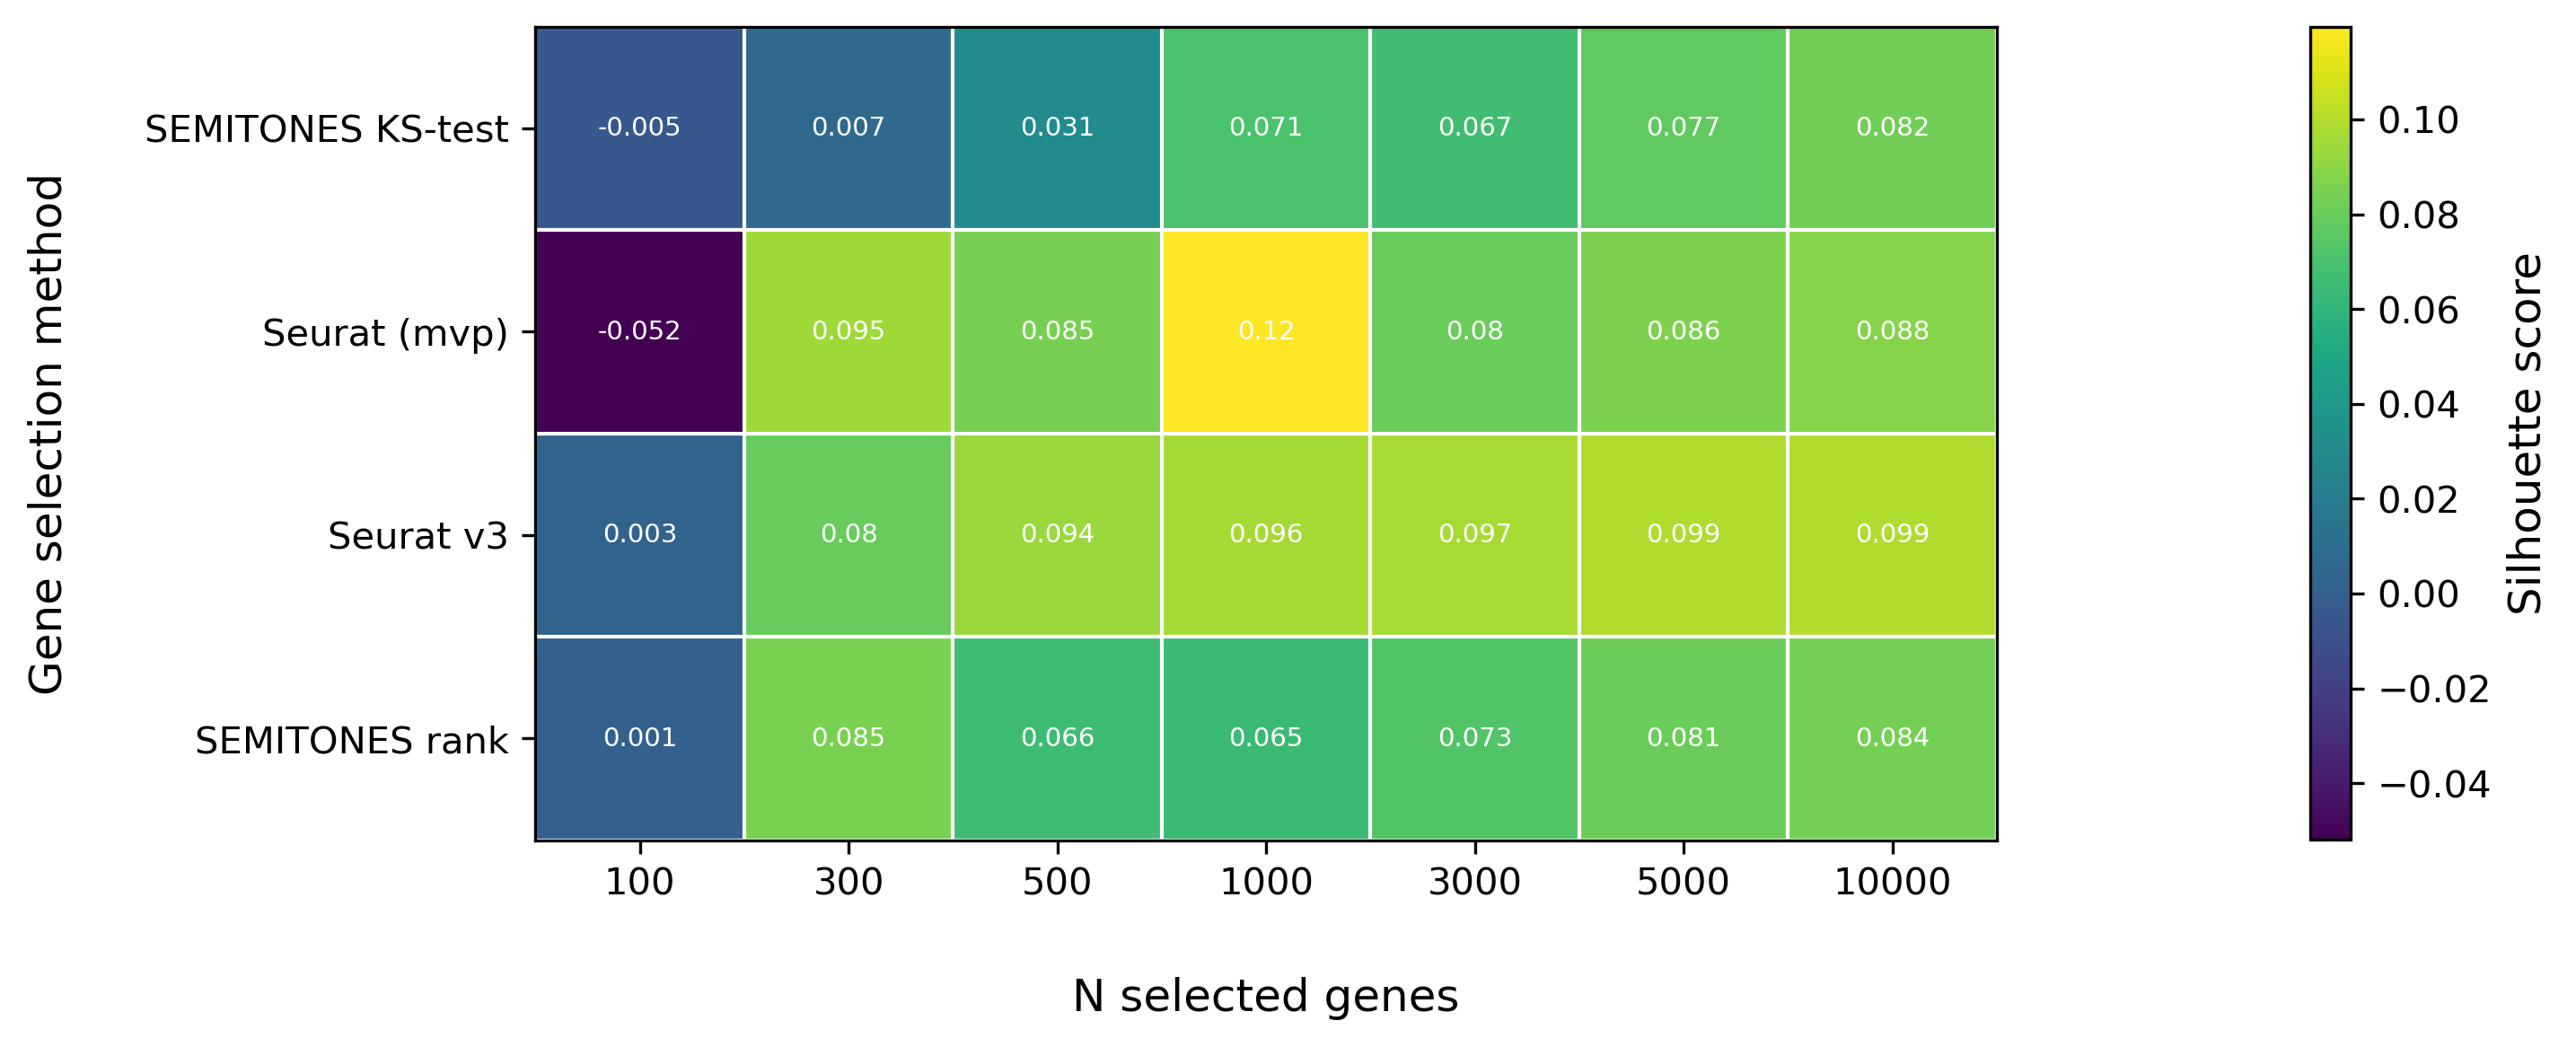

In [22]:
plt.figure(figsize=(10, 4), dpi=300)
plt.imshow(silscores, aspect="auto")
cbar = plt.colorbar(pad=.15)
cbar.ax.set_ylabel("Silhouette score", fontsize=12)
ax = plt.gca()

nrows, ncols = 4, 7

ax.set_xticks(range(ncols))
ax.set_xticklabels(silscores.columns)
ax.set_xlabel("N selected genes", labelpad=20, fontsize=12)

ax.set_yticks(range(nrows))
# CHECK THIS
ax.set_yticklabels(["SEMITONES KS-test", "Seurat (mvp)", "Seurat v3", "SEMITONES rank"])
ax.set_ylabel("Gene selection method", labelpad=20, fontsize=12)

# create text annotations
for i in range(nrows):
    for j in range(ncols):
        text = ax.text(j, i, round(silscores.iloc[i, j], 3),
                       ha="center", va="center", color="w",
                       fontsize=7)

ax.set_xticks(np.arange(ncols+1)-.5, minor=True)
ax.set_yticks(np.arange(nrows+1)-.5, minor=True)
ax.grid(b=True, which="minor", axis="both", color="white", linestyle="-", linewidth=1)
ax.tick_params(which="minor", bottom=False, left=False)

### c. Check cluster seperation in 2D UMAPs

#### i. Map the annotations to colours

In [23]:
# load the barcodes for the order
with open("../data/processed/greenleaf_scRNA_combined_filtered_barcodes.txt", "r") as f:
    barcodes = [b.strip("\n") for b in f.readlines()]
f.close()

# laod the metadata
metadata = pd.read_csv(
    "../data/external/greenleaf_scRNA_cell_metadata.txt",
    sep="\t") 
# rearrange the metadata
metadata["cell_id"] = metadata.Group + ":" + metadata.Barcode
metadata = metadata.set_index("cell_id")
metadata = metadata.reindex(barcodes)
annots = metadata.BioClassification.values

# make a colour map
colours = ["#b29785", "#d8776c", "#B92819",
           "#ef9d0e", "#8E6B52", "#a1d1e6",
           "#c68a55", "#d16200", "#7cc9b3",
           "#8bcc84", "#deca7c", "#ccac1e",
           "#af910a", "#e4e4e4", "#87abbc",
           "#007fad", "#01587a", "#37797a",
           "#b7a9cc", "#e0b8cf", "#d88ab8",
           "#a8648b", "#726287", "#9c8db7",
           "#5e659b", "#e4e4e4"]
coldict = dict(zip(np.unique(annots), colours))

# map annotations to colours
cols = annots
for a, c in coldict.items():
    cols = [c if i == a else i for i in cols]

#### ii. Plots from ranked SEMITONES genes

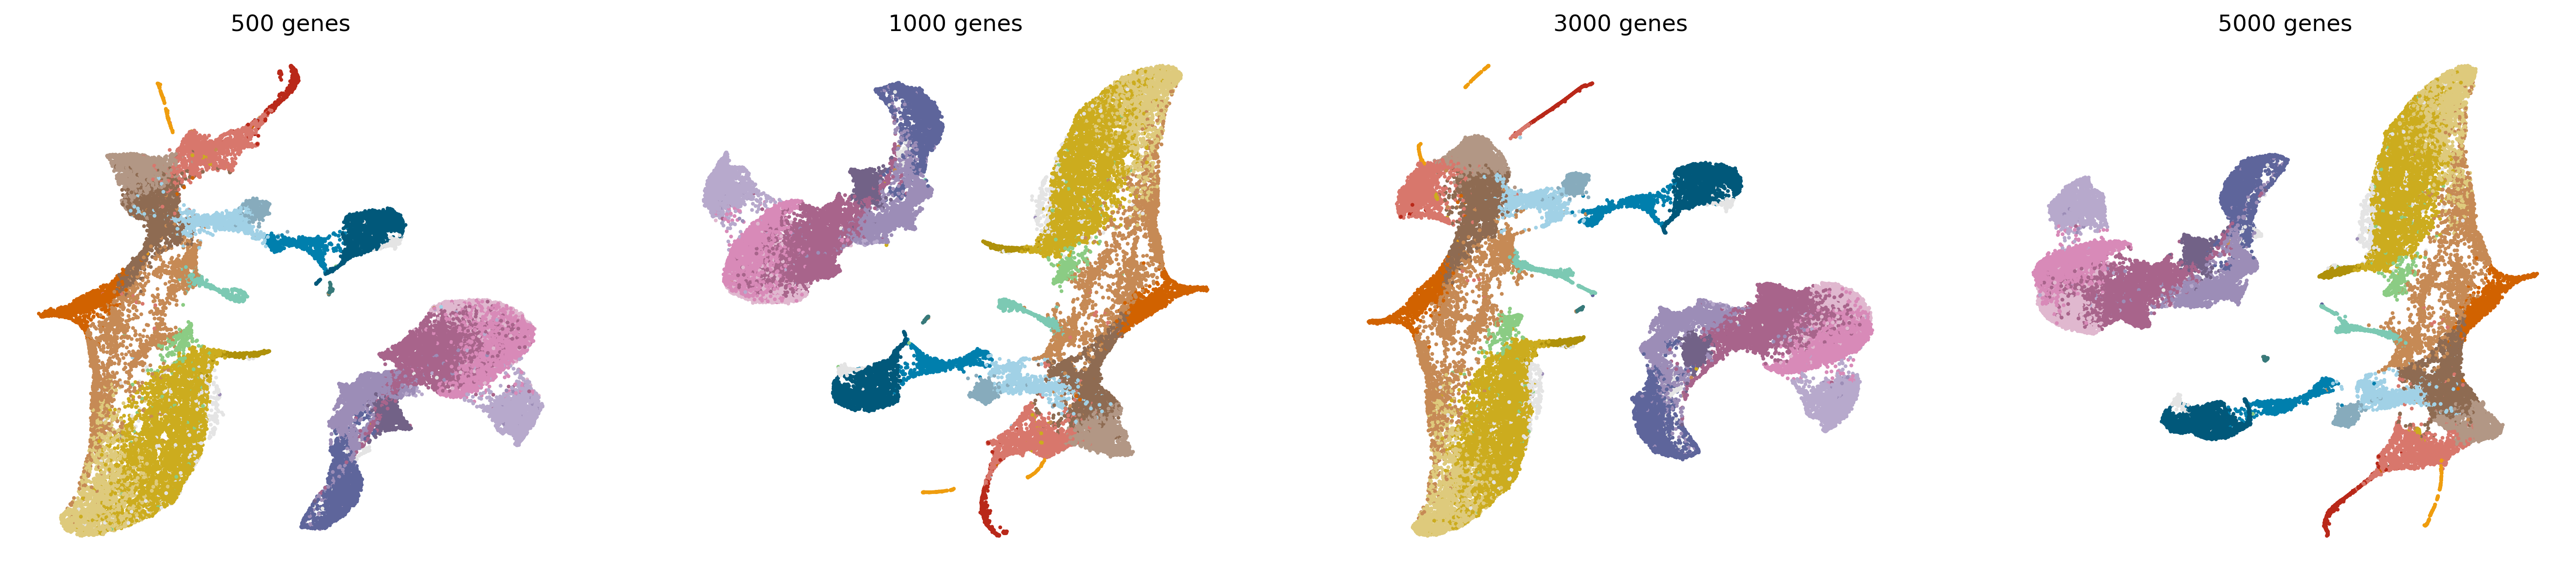

In [24]:
ns = [500, 1000, 3000, 5000]  # number of genes

fig, axs = plt.subplots(1, 4, figsize=(24, 5), dpi=300)
for n, ax in zip(ns, axs):
    # load the UMAPs computed in the density scoring script
    u = np.load(
        f"sem_rank_umap_{n}genes.npy"
    )
    ax.scatter(u[:, 0], u[:, 1], s=1, c=cols)
    ax.set_title(f"{n} genes")
    ax.axis("off")

#### iii. Plot from KS-tested SEMITONES scores

#### ii. Plots from KS-test genes

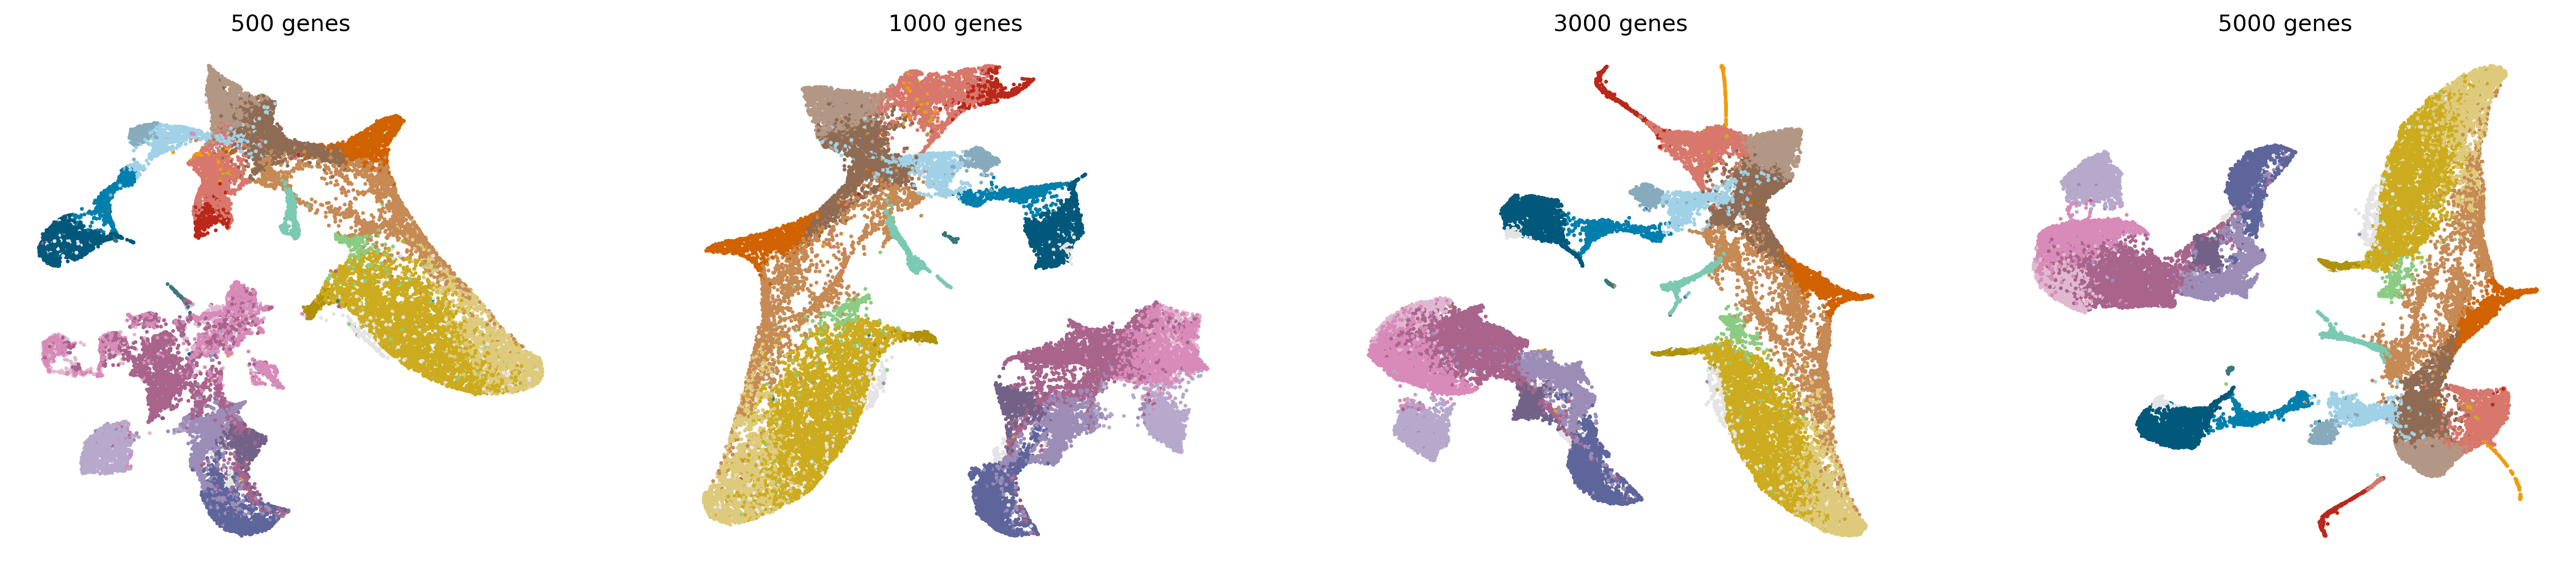

In [25]:
ns = [500, 1000, 3000, 5000]  # number of genes

fig, axs = plt.subplots(1, 4, figsize=(24, 5), dpi=300)
for n, ax in zip(ns, axs):
    # load the UMAPs computed in the density scoring script
    u = np.load(
        f"semitones_umap_{n}genes.npy"
    )
    ax.scatter(u[:, 0], u[:, 1], s=1, c=cols)
    ax.set_title(f"{n} genes")
    ax.axis("off")